<a href="https://colab.research.google.com/github/ethanol-lo/scoutout/blob/main/ScoutOut_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ScoutOut Regression Scoring System for Off-Market/High Value Real Estate Deals

# Key Features


*   Rental Payments
*   Lease agreements
*   Profits from property sales
*   Rental yield (cap rate)
*   Occupancy rates
*   Property taxes
*   Location
*   Carrying costs
*   Potential ROI
*   Condition
*   Age of property

# Imports

In [ ]:
!pip install kagglehub

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, r2_score

# add more later as needed

# Dataset Download

Read and download the Kaggle dataset's description here: https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset?resource=download

In [ ]:
kagglehub.dataset_download('ahmedshahriarsakib/usa-real-estate-dataset')

'/kaggle/input/usa-real-estate-dataset'

In [ ]:
df = pd.read_csv('/root/.cache/kagglehub/datasets/ahmedshahriarsakib/usa-real-estate-dataset/versions/25/realtor-data.zip.csv')
# df = pd.read_csv('/kaggle/input/usa-real-estate-dataset/realtor-data.zip.csv')

Zillow ZHVI and ZORI datasets by ZIP code

In [ ]:
!curl -L "https://files.zillowstatic.com/research/public_csvs/zhvi/Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv?t=1750628512" -o "Zip_Zhvi_AllHomes.csv"
!curl -L "https://files.zillowstatic.com/research/public_csvs/zori/Zip_zori_uc_sfrcondomfr_sm_sa_month.csv?t=1750727190" -o "ZORI_AllHomesPlusMultifamily_SSA.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  110M  100  110M    0     0  92.2M      0  0:00:01  0:00:01 --:--:-- 92.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7794k  100 7794k    0     0  17.9M      0 --:--:-- --:--:-- --:--:-- 17.9M


# Data Cleaning

In [ ]:
df.head()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN


In [ ]:
df.shape

(2226382, 12)

The dataset has 2,226,382 entries with 12 attributes for each entry

In [ ]:
df.isnull().sum()

,0
brokered_by,4533
status,0
price,1541
bed,481317
bath,511771
acre_lot,325589
street,10866
city,1407
state,8
zip_code,299


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226382 entries, 0 to 2226381
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   brokered_by     float64
 1   status          object 
 2   price           float64
 3   bed             float64
 4   bath            float64
 5   acre_lot        float64
 6   street          float64
 7   city            object 
 8   state           object 
 9   zip_code        float64
 10  house_size      float64
 11  prev_sold_date  object 
dtypes: float64(8), object(4)
memory usage: 203.8+ MB


In [ ]:
df.describe()

,brokered_by,price,bed,bath,acre_lot,street,zip_code,house_size
count,2.221849e+06,2.224841e+06,1.745065e+06,1.714611e+06,1.900793e+06,2.215516e+06,2.226083e+06,1.657898e+06
mean,5.293989e+04,5.241955e+05,3.275841e+00,2.496440e+00,1.522303e+01,1.012325e+06,5.218668e+04,2.714471e+03
std,3.064275e+04,2.138893e+06,1.567274e+00,1.652573e+00,7.628238e+02,5.837635e+05,2.895408e+04,8.081635e+05
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
25%,2.386100e+04,1.650000e+05,3.000000e+00,2.000000e+00,1.500000e-01,5.063128e+05,2.961700e+04,1.300000e+03
50%,5.288400e+04,3.250000e+05,3.000000e+00,2.000000e+00,2.600000e-01,1.012766e+06,4.838200e+04,1.760000e+03
75%,7.918300e+04,5.500000e+05,4.000000e+00,3.000000e+00,9.800000e-01,1.521173e+06,7.807000e+04,2.413000e+03
max,1.101420e+05,2.147484e+09,4.730000e+02,8.300000e+02,1.000000e+05,2.001357e+06,9.999900e+04,1.040400e+09


In [ ]:
print('# of states:', df['state'].nunique())
print('States List:', df['state'].unique())

# of states: 55
States List: ['Puerto Rico' 'Virgin Islands' 'Massachusetts' 'Connecticut'
 'New Hampshire' 'Vermont' 'New Jersey' 'New York' 'South Carolina'
 'Tennessee' 'Rhode Island' 'Virginia' 'Wyoming' 'Maine' 'Georgia'
 'Pennsylvania' 'West Virginia' 'Delaware' 'Louisiana' 'Ohio' 'California'
 'Colorado' 'Maryland' 'Missouri' 'District of Columbia' 'Wisconsin'
 'North Carolina' 'Kentucky' 'Michigan' 'Mississippi' 'Florida' 'Alabama'
 'New Brunswick' nan 'Texas' 'Arkansas' 'Idaho' 'Indiana' 'Illinois'
 'New Mexico' 'Iowa' 'Minnesota' 'South Dakota' 'Nebraska' 'North Dakota'
 'Montana' 'Oklahoma' 'Kansas' 'Oregon' 'Utah' 'Nevada' 'Washington'
 'Arizona' 'Hawaii' 'Guam' 'Alaska']


Drop rows we don't need

In [ ]:
df = df.drop(['brokered_by', 'street'], axis=1)

Drop rows with null or NAN values

In [ ]:
df.dropna(subset = ['zip_code', 'price', 'bed', 'bath', 'state', 'city', 'prev_sold_date'], inplace=True)

In [ ]:
df.shape

(1323428, 10)

<Axes: >

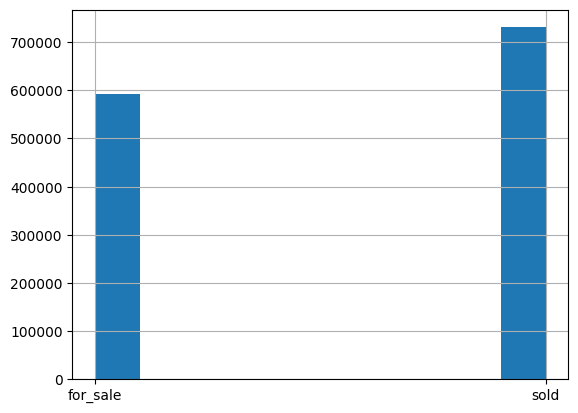

In [ ]:
df.status.hist()

Fill acre_lot and house_size with the median

In [ ]:
df['acre_lot'].fillna(df['acre_lot'].median(), inplace = True)
df['house_size'].fillna(df['house_size'].median(), inplace = True)

/tmp/ipython-input-161-322553504.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['acre_lot'].fillna(df['acre_lot'].median(), inplace = True)
/tmp/ipython-input-161-322553504.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

In [ ]:
print('acre_lot median:', df['acre_lot'].median())
print('house_size median:', df['house_size'].median())

acre_lot median: 0.21
house_size median: 1720.0


In [ ]:
df = df.loc[df['acre_lot'].astype(float) != 0.0]
df = df.loc[df['house_size'].astype(float) != 0.0]

In [ ]:
df.isnull().sum()

,0
status,0
price,0
bed,0
bath,0
acre_lot,0
city,0
state,0
zip_code,0
house_size,0
prev_sold_date,0


In [ ]:
df.shape

(1321827, 10)

In [ ]:
# convert prev_sold_date column to datetime objects

df['prev_sold_date'] = pd.to_datetime(df['prev_sold_date'], errors='coerce')

Create labels for previous sold month and year

In [ ]:
df['prev_sold_year'] = df['prev_sold_date'].dt.year

df = df.dropna(subset = ['prev_sold_year'])

Create label for years since last sold

In [ ]:
from datetime import datetime

current_year = datetime.now().year

df['years_held'] = current_year - df['prev_sold_year']

/tmp/ipython-input-168-4241642138.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['years_held'] = current_year - df['prev_sold_year']


Create additional labels, such as ratios and price per features

In [ ]:
df['price_per_sqft'] = df['price'] / (df['house_size'].replace(0, np.nan))
df['bed_bath_ratio'] = df['bed'] / (df['bath'].replace(0, np.nan))
df['house_lot_ratio'] = df['house_size'] / df['acre_lot'].replace(0, np.nan)

In [ ]:
df = df.dropna(subset = ['price_per_sqft', 'bed_bath_ratio', 'house_lot_ratio'])

In [ ]:
df = df.drop('prev_sold_date', axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1321826 entries, 411 to 2226381
Data columns (total 14 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   status           1321826 non-null  object 
 1   price            1321826 non-null  float64
 2   bed              1321826 non-null  float64
 3   bath             1321826 non-null  float64
 4   acre_lot         1321826 non-null  float64
 5   city             1321826 non-null  object 
 6   state            1321826 non-null  object 
 7   zip_code         1321826 non-null  float64
 8   house_size       1321826 non-null  float64
 9   prev_sold_year   1321826 non-null  float64
 10  years_held       1321826 non-null  float64
 11  price_per_sqft   1321826 non-null  float64
 12  bed_bath_ratio   1321826 non-null  float64
 13  house_lot_ratio  1321826 non-null  float64
dtypes: float64(11), object(3)
memory usage: 151.3+ MB


In [ ]:
df.head()

,status,price,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_year,years_held,price_per_sqft,bed_bath_ratio,house_lot_ratio
411,for_sale,76900.0,3.0,2.0,0.21,Canovanas,Puerto Rico,729.0,1200.0,2020.0,5.0,64.083333,1.500000,5714.285714
502,for_sale,110000.0,7.0,3.0,0.09,Dorado,Puerto Rico,949.0,1192.0,2019.0,6.0,92.281879,2.333333,13244.444444
1025,for_sale,159000.0,3.0,2.0,0.21,Caguas,Puerto Rico,725.0,1625.0,2021.0,4.0,97.846154,1.500000,7738.095238
2270,for_sale,950000.0,5.0,4.0,0.99,Saint Thomas,Virgin Islands,802.0,5000.0,2013.0,12.0,190.000000,1.250000,5050.505051
2277,for_sale,6899000.0,4.0,6.0,0.83,Saint Thomas,Virgin Islands,802.0,4600.0,2018.0,7.0,1499.782609,0.666667,5542.168675


# Encode Data

In [ ]:
city_encoder = LabelEncoder()
state_encoder = LabelEncoder()
prev_sold_year_encoder = LabelEncoder()
status_encoder = LabelEncoder()

categorical_features = ['city','state', 'status', 'prev_sold_year']

for feature in categorical_features:
  df[feature] = eval(feature + '_encoder').fit_transform(df[feature])

In [ ]:
df.head()

,status,price,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_year,years_held,price_per_sqft,bed_bath_ratio,house_lot_ratio
411,0,76900.0,3.0,2.0,0.21,2003,39,729.0,1200.0,80,5.0,64.083333,1.500000,5714.285714
502,0,110000.0,7.0,3.0,0.09,3653,39,949.0,1192.0,79,6.0,92.281879,2.333333,13244.444444
1025,0,159000.0,3.0,2.0,0.21,1881,39,725.0,1625.0,81,4.0,97.846154,1.500000,7738.095238
2270,0,950000.0,5.0,4.0,0.99,12196,47,802.0,5000.0,73,12.0,190.000000,1.250000,5050.505051
2277,0,6899000.0,4.0,6.0,0.83,12196,47,802.0,4600.0,78,7.0,1499.782609,0.666667,5542.168675


# Incorporating ZHVI and ZORI from Zillow's datasets for curated investment potential score

In [ ]:
# Load the Zillow datasets
zhvi_df = pd.read_csv("/content/Zip_Zhvi_AllHomes.csv")
zori_df = pd.read_csv("/content/ZORI_AllHomesPlusMultifamily_SSA.csv")

# Use the most recent available month
latest_month = zhvi_df.columns[-1]
latest_month_1_year_ago = zhvi_df.columns[-13]

# Select relevant columns
zhvi_df_filtered = zhvi_df[['RegionName', latest_month, latest_month_1_year_ago]].copy()
zhvi_df_filtered.columns = ['zip_code', 'zhvi', 'zhvi_1_year_ago']

zori_df_filtered = zori_df[['RegionName', latest_month]].copy()
zori_df_filtered.columns = ['zip_code', 'zori']

# Merge on zip_code
location_scores = pd.merge(zhvi_df_filtered, zori_df_filtered, on='zip_code', how='inner')

# Clean data
location_scores = location_scores.dropna(subset=['zhvi', 'zhvi_1_year_ago', 'zori'])
location_scores = location_scores[(location_scores['zhvi'] > 0) & (location_scores['zori'] > 0) & (location_scores['zhvi_1_year_ago'] > 0)]

# Compute rental yield and appreciation score and normalize it
location_scores['rental_yield'] = (location_scores['zori'] * 12) / location_scores['zhvi'] # calculating gross rental yield (find webscraping info about operating expenses)
location_scores['appreciation_score'] = (location_scores['zhvi'] - location_scores['zhvi_1_year_ago']) / location_scores['zhvi_1_year_ago'] # calculating appreciation score

# Preview top ZIPs
print(location_scores.sort_values(by='rental_yield', ascending=False).head(10))
print(location_scores.sort_values(by='appreciation_score', ascending=False).head(10))

      zip_code          zhvi  zhvi_1_year_ago          zori  rental_yield  \
7401     71103  2.879557e+04     3.145916e+04    847.500000      0.353179   
3562     39209  4.201328e+04     3.786264e+04   1191.666667      0.340369   
6753     61605  3.546081e+04     3.314871e+04    993.250000      0.336118   
6740     62206  5.175265e+04     5.148566e+04   1445.833333      0.335249   
6184     39204  4.244042e+04     3.752262e+04   1159.750000      0.327919   
6902     36105  4.781904e+04     5.148428e+04   1247.500000      0.313055   
7505     11978  1.570415e+06     1.525563e+06  39666.666667      0.303105   
7103     36104  6.264444e+04     7.833575e+04   1545.333333      0.296020   
5648     71109  3.531554e+04     4.246862e+04    823.611111      0.279858   
3017     48205  5.711200e+04     5.506820e+04   1315.099206      0.276320   

      appreciation_score  
7401           -0.084668  
3562            0.109624  
6753            0.069750  
6740            0.005186  
6184            0

In [ ]:
location_scores['zip_code'].nunique()

7583

In [ ]:
df['zip_code'].nunique()

25396

In [ ]:
zori_df_filtered['zip_code'].nunique()

7607

In [ ]:
zhvi_df_filtered['zip_code'].nunique()

26316

Warning: Here Zillow only provides around 7.6k zip codes of ZORI data whereas there is 26.3k zip codes of ZHVI data. This thus cuts down the amount of data heavily

In [ ]:
# location_scores contains: 'zip_code', 'zhvi', 'zori', 'rental_yield', 'apprecation_score'
location_scores[['zip_code', 'rental_yield', 'appreciation_score']].head()


,zip_code,rental_yield,appreciation_score
0,77494,0.047945,-0.002997
1,77449,0.082452,-0.022692
2,77084,0.074801,-0.021275
3,79936,0.084460,0.013446
4,11385,0.043305,0.025257


In [ ]:
df['zip_code'].nunique()

25396

In [ ]:
location_scores['zip_code'].nunique()

7583

In [ ]:
# Ensure zip_code is the same dtype (string or int)
df['zip_code'] = df['zip_code'].astype(int).astype(str)
location_scores['zip_code'] = location_scores['zip_code'].astype(int).astype(str)

# Merge
merged_df = df.merge(location_scores[['zip_code', 'rental_yield', 'appreciation_score']],
                               on='zip_code', how='left')

# Remove missing scores
merged_df = merged_df.dropna()

merged_df.shape


(1027912, 16)

In [ ]:
merged_df.isnull().sum()

,0
status,0
price,0
bed,0
bath,0
acre_lot,0
city,0
state,0
zip_code,0
house_size,0
prev_sold_year,0


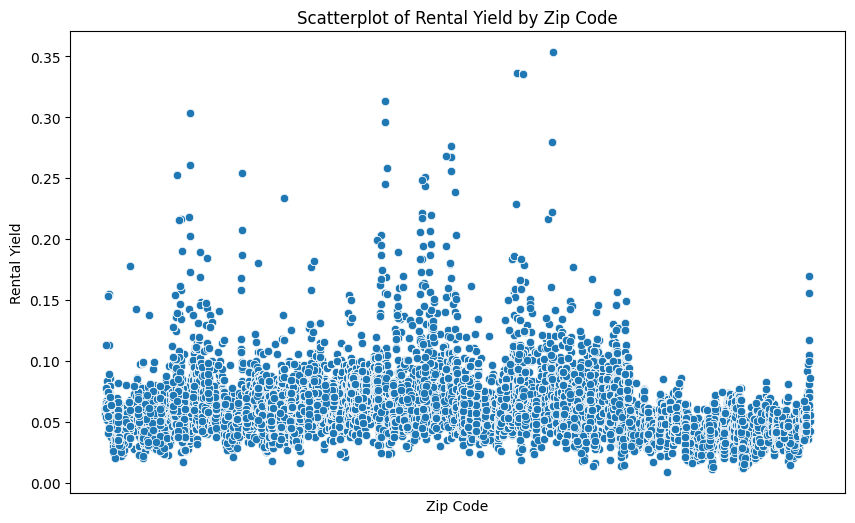

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, y='rental_yield', x='zip_code')
plt.title('Scatterplot of Rental Yield by Zip Code')
plt.xlabel('Zip Code')
plt.ylabel('Rental Yield')
plt.xticks([]) # Hide x-axis ticks for better visualization given the large number of zip codes
plt.show()

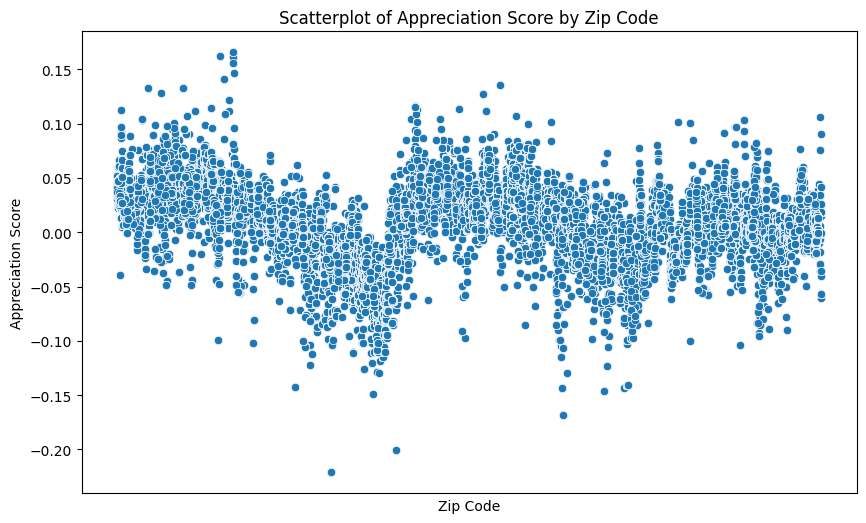

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, y='appreciation_score', x='zip_code')
plt.title('Scatterplot of Appreciation Score by Zip Code')
plt.xlabel('Zip Code')
plt.ylabel('Appreciation Score')
plt.xticks([]) # Hide x-axis ticks for better visualization given the large number of zip codes
plt.show()

<Axes: >

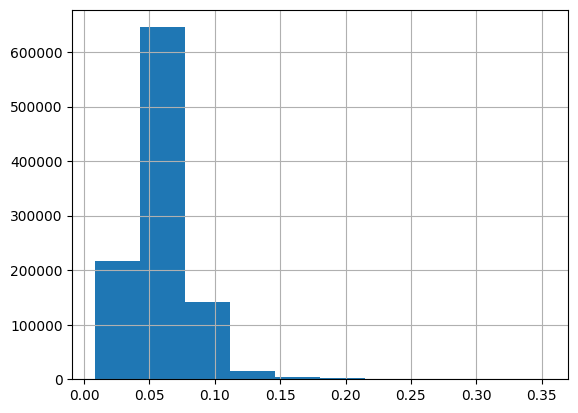

In [ ]:
merged_df.rental_yield.hist()

<Axes: >

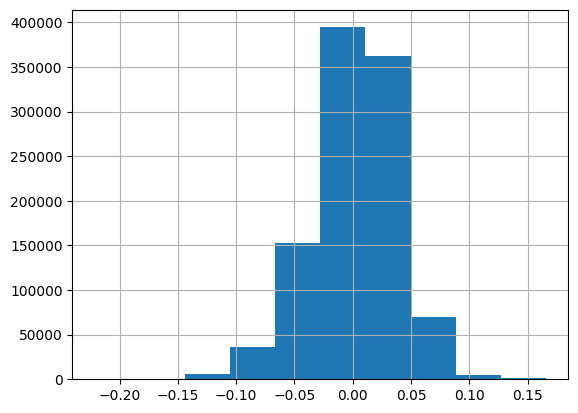

In [ ]:
merged_df.appreciation_score.hist()

# Creating the investment potential score

We want to build an investment potential score that looks like this: rental_yield * value_bonus + appreciation_score * feature_bonus

Combining zip code-based scores with property-specific features allows for a more property-specific score

value_bonus adjuts rental yield because it determines how cheaply rental income is acquired, while feature_bonus adjusts appreciation_score because it determines how desirable the property is long-term.

In [ ]:
merged_df.shape

(1027912, 16)

In [ ]:
# Compute avg price_per_sqft by ZIP
zip_ppsq = merged_df.groupby('zip_code')['price_per_sqft'].mean().rename('zip_avg_ppsq')
merged_df = merged_df.merge(zip_ppsq, on='zip_code', how='left')

# Compute relative value
merged_df['value_bonus'] = (merged_df['price_per_sqft'].replace(0, np.nan)) / merged_df['zip_avg_ppsq']
merged_df.dropna(subset=['value_bonus'], inplace=True)

# If the property has a higher price per sqft, then it usually implies better maintenance and higher quality


In [ ]:
# If it has been 10-15 years since the property was last sold, there is a risk of aging systems and upgrades and renovations may be needed
# If it has been 15-27.5 years, and without renovations, it may start losing value relative to competition
# If it has been 27.5+ years, tax benefits diminish significantly for rental properties by IRS, making it less attractive from a cash flow perspective. Also property gonna be pretty old
merged_df.loc[(merged_df['years_held'] >= 10) & (merged_df['years_held'] < 15), 'years_held'] *= -1
merged_df.loc[(merged_df['years_held'] >= 15) & (merged_df['years_held'] < 27.5), 'years_held'] *= -1.25
merged_df.loc[merged_df['years_held'] >= 27.5, 'years_held'] *= -1.5

# Normalize key features
scaler = MinMaxScaler()
merged_df[['bb_ratio_norm', 'hl_ratio_norm', 'years_held_norm']] = scaler.fit_transform(
    merged_df[['bed_bath_ratio', 'house_lot_ratio', 'years_held']]
)

# Combine with equal weights
merged_df['feature_bonus'] = (
    (1.0/3) * (merged_df['bb_ratio_norm'] + merged_df['hl_ratio_norm'] + merged_df['years_held_norm'])
)

# A bedroom to bathroom ratio closer to 1 indicates a more equal number of bedrooms and bathrooms and thus greater value
# A house size to property lot ratio closer to 1 indicates that most of the house is within the property lot and thus greater value
# The longer it has been since the house was last sold, the less the house is valued (due to maintenance issues and other)

In [ ]:
# Calculate investment potential score
merged_df['investment_potential_score'] = (
    merged_df['rental_yield'] * merged_df['value_bonus'] +
    merged_df['appreciation_score'] * merged_df['feature_bonus']
)

In [ ]:
merged_df.shape

(1027911, 23)

In [ ]:
merged_df.head()

,status,price,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_year,...,house_lot_ratio,rental_yield,appreciation_score,zip_avg_ppsq,value_bonus,bb_ratio_norm,hl_ratio_norm,years_held_norm,feature_bonus,investment_potential_score
0,0,419000.0,4.0,2.0,2.00,10688,21,1002,1607.0,65,...,803.500000,0.05639,0.043348,249.170208,1.046410,0.020743,0.000021,0.820106,0.280290,0.071157
1,0,745000.0,4.0,3.0,0.56,269,21,1002,2847.0,52,...,5083.928571,0.05639,0.043348,249.170208,1.050202,0.013798,0.000130,0.690476,0.234801,0.069399
2,0,875000.0,4.0,4.0,1.50,10688,21,1002,4366.0,56,...,2910.666667,0.05639,0.043348,249.170208,0.804319,0.010325,0.000075,0.722222,0.244207,0.055941
3,0,699900.0,4.0,4.0,0.77,269,21,1002,3879.0,53,...,5037.662338,0.05639,0.043348,249.170208,0.724136,0.010325,0.000129,0.698413,0.236289,0.051076
4,0,275000.0,3.0,2.0,0.16,269,21,1002,1280.0,81,...,8000.000000,0.05639,0.043348,249.170208,0.862237,0.015534,0.000205,0.973545,0.329761,0.062916


Remove outliers using interquartile range

In [ ]:
# Calculate Q1, Q3, and IQR
Q1 = merged_df['investment_potential_score'].quantile(0.25)
Q3 = merged_df['investment_potential_score'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 2.0 * IQR
upper_bound = Q3 + 2.0 * IQR

# Filter out outliers
merged_df = merged_df[(merged_df['investment_potential_score'] >= lower_bound) & (merged_df['investment_potential_score'] <= upper_bound)]

In [ ]:
#Normalize to [0, 1]
score_scaler = MinMaxScaler()
merged_df['investment_potential_score_norm'] = score_scaler.fit_transform(merged_df[['investment_potential_score']])


/tmp/ipython-input-229-2306846739.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['investment_potential_score_norm'] = score_scaler.fit_transform(merged_df[['investment_potential_score']])


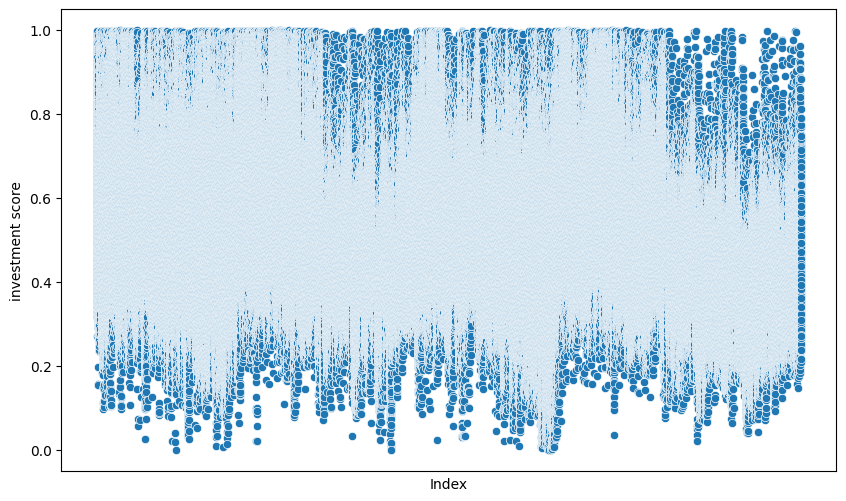

In [ ]:
plt.figure(figsize=(10, 6))
merged_df = merged_df.reset_index()
sns.scatterplot(data=merged_df, y='investment_potential_score_norm', x='index')
plt.xlabel('Index')
plt.ylabel('investment score')
plt.xticks([]) # Hide x-axis ticks for better visualization given the large number of zip codes
plt.show()

<Axes: >

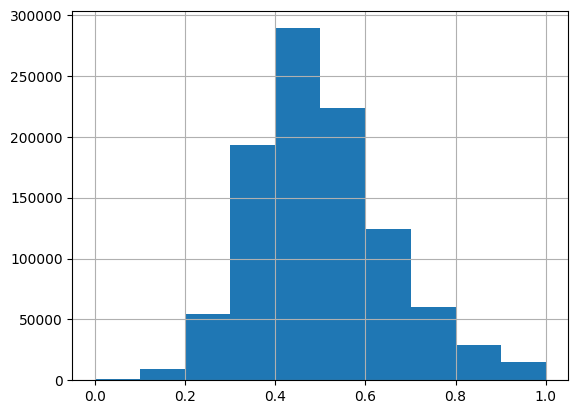

In [ ]:
merged_df.investment_potential_score_norm.hist()

In [ ]:
merged_df.shape

(1000677, 25)

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000677 entries, 0 to 1000676
Data columns (total 25 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   index                            1000677 non-null  int64  
 1   status                           1000677 non-null  int64  
 2   price                            1000677 non-null  float64
 3   bed                              1000677 non-null  float64
 4   bath                             1000677 non-null  float64
 5   acre_lot                         1000677 non-null  float64
 6   city                             1000677 non-null  int64  
 7   state                            1000677 non-null  int64  
 8   zip_code                         1000677 non-null  object 
 9   house_size                       1000677 non-null  float64
 10  prev_sold_year                   1000677 non-null  int64  
 11  years_held                       1000677 non-null 

# Standardizing Data

In [ ]:
bed_encoder = StandardScaler()
bath_encoder = StandardScaler()
house_size_encoder = StandardScaler()
acre_lot_encoder = StandardScaler()
price_encoder = StandardScaler()
price_per_sqft_encoder = StandardScaler()
bed_bath_ratio_encoder = StandardScaler()
house_lot_ratio_encoder = StandardScaler()

columns_to_scale = ['bed', 'bath', 'house_size', 'acre_lot', 'price', 'price_per_sqft', 'bed_bath_ratio', 'house_lot_ratio']

for feature in columns_to_scale:
  merged_df[feature] = eval(feature + '_encoder').fit_transform(merged_df[[feature]])

merged_df.head()

,index,status,price,bed,bath,acre_lot,city,state,zip_code,house_size,...,rental_yield,appreciation_score,zip_avg_ppsq,value_bonus,bb_ratio_norm,hl_ratio_norm,years_held_norm,feature_bonus,investment_potential_score,investment_potential_score_norm
0,0,0,-0.172008,0.607915,-0.346091,-0.009936,10688,21,1002,-0.143320,...,0.05639,0.043348,249.170208,1.046410,0.020743,0.000021,0.820106,0.280290,0.071157,0.593123
1,1,0,0.157860,0.607915,0.336843,-0.011933,269,21,1002,0.325892,...,0.05639,0.043348,249.170208,1.050202,0.013798,0.000130,0.690476,0.234801,0.069399,0.582085
2,2,0,0.289403,0.607915,1.019776,-0.010630,10688,21,1002,0.900676,...,0.05639,0.043348,249.170208,0.804319,0.010325,0.000075,0.722222,0.244207,0.055941,0.497584
3,3,0,0.112225,0.607915,1.019776,-0.011642,269,21,1002,0.716397,...,0.05639,0.043348,249.170208,0.724136,0.010325,0.000129,0.698413,0.236289,0.051076,0.467039
4,4,0,-0.317717,-0.189750,-0.346091,-0.012488,269,21,1002,-0.267055,...,0.05639,0.043348,249.170208,0.862237,0.015534,0.000205,0.973545,0.329761,0.062916,0.541378


# Regression Model

In [ ]:
# convert categorical features to category datatypes

merged_df['zip_code'] = merged_df['zip_code'].astype('category')
merged_df['city'] = merged_df['city'].astype('category')
merged_df['state'] = merged_df['state'].astype('category')
merged_df['status'] = merged_df['status'].astype('category')

In [ ]:
merged_df.drop(['index', 'rental_yield', 'appreciation_score', 'zip_avg_ppsq', 'years_held', 'value_bonus', 'bb_ratio_norm', 'hl_ratio_norm', 'years_held_norm', 'feature_bonus', 'investment_potential_score'], axis=1, inplace=True)

In [ ]:
merged_df.head()

In [ ]:
# Reassign X and y, split the data into training and testing

X = merged_df.drop('investment_potential_score_norm', axis=1)
y = merged_df['investment_potential_score_norm']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.info()

In [ ]:
model = XGBRegressor(enable_categorical = True)

model.fit(X_train, y_train)

predictions = model.predict(X_test)

print(f"MAE: {mean_absolute_error(y_test, predictions)}")
print(f"r2 score: {r2_score(y_test, predictions)}")

MAE: 0.03354915060967207
r2 score: 0.9108539021150002


In [ ]:
model.feature_importances_

array([3.97338346e-02, 3.72462766e-03, 2.79046074e-02, 6.34631664e-02,
       1.98277235e-02, 1.08716115e-02, 6.52312696e-01, 7.09090531e-02,
       6.75304234e-02, 1.89568949e-04, 1.42765930e-02, 1.01232985e-02,
       1.91328675e-02], dtype=float32)

In [ ]:
predictions_20 = model.predict(X_test[:20])

In [ ]:
predictions_subset = X_test[:20]
predictions_subset['predictions'] = predictions_20
predictions_subset['actual'] = y_test[:20]

predictions_subset

/tmp/ipython-input-241-3352703699.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_subset['predictions'] = predictions_20
/tmp/ipython-input-241-3352703699.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_subset['actual'] = y_test[:20]


,status,price,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_year,price_per_sqft,bed_bath_ratio,house_lot_ratio,predictions,actual
495005,1,1.325554,0.607915,1.019776,-0.012655,14645,8,20001,0.374327,82,1.296393,-0.752880,1.430940,0.342786,0.359683
596993,1,-0.167960,-0.189750,0.336843,-0.012349,8130,9,32444,0.173398,82,-0.464716,-0.752880,-0.088137,0.566894,0.585151
730274,1,-0.505418,-0.987415,-1.029025,-0.012516,1397,18,71111,-0.327598,82,-0.817384,1.050238,-0.120869,0.503396,0.416856
608107,1,-0.191233,1.405580,0.336843,-0.012641,3346,9,33896,0.200264,82,-0.517830,0.449199,0.868081,0.385688,0.357183
265987,0,-0.332996,-0.189750,0.336843,-0.012488,6875,25,64157,-0.139914,80,-0.511078,-0.752880,-0.071772,0.602340,0.571911
401673,0,0.719446,1.405580,2.385644,-0.012474,1535,4,94513,0.724721,75,0.141588,-1.053399,0.228585,0.397263,0.393228
613325,1,-0.348073,-0.987415,-0.346091,-0.012613,8683,9,32940,-0.313598,82,-0.318308,-0.752880,0.078524,0.386603,0.384224
796965,1,0.162869,1.405580,1.702710,-0.012460,13424,44,77498,0.866998,82,-0.456131,-0.752880,0.247617,0.500480,0.583960
768366,1,-0.222601,-0.189750,-0.346091,-0.012571,4841,44,76179,-0.039261,82,-0.377687,0.148679,0.132097,0.586067,0.663462
806614,1,-0.115343,0.607915,0.336843,-0.012488,4107,44,79912,0.172263,82,-0.383273,-0.151840,0.048778,0.712169,0.761928


In [ ]:
# prompt: Find rows where investment potential score norm is above 0.9 and inverse transform the values that were standardized and decode the city, state, and prev_sold_year.

# Filter for rows where investment_potential_score_norm is above 0.9
high_potential_df = merged_df[merged_df['investment_potential_score_norm'] > 0.9].copy()

# Inverse transform the standardized numerical features
# We need to re-apply the inverse transform using the original scalers.
# Since the dataframe was filtered after standardization, we need to access the original scaled columns before filtering if we were to inverse transform all columns.
# However, the request only asks for inverse transforming specific columns if they were standardized and filtering is based on the *normalized* investment potential score, not the standardized features used in the regression model.
# The numerical features that were standardized (`bed`, `bath`, `house_size`, `acre_lot`, `price`, `price_per_sqft`, `bed_bath_ratio`, `house_lot_ratio`) were done *after* the investment potential score was calculated and normalized.
# Thus, the values in `high_potential_df` for these columns are the standardized values.
# We need to perform the inverse transform on these columns.

# Define a function to inverse transform using the correct scaler
def inverse_transform_column(df, column_name, scaler):
    # Ensure the column is in the dataframe and is a numpy array (required by inverse_transform)
    if column_name in df.columns:
        # The scaler expects a 2D array, so reshape the column data
        df[column_name + '_original'] = scaler.inverse_transform(df[[column_name]])
    else:
        print(f"Column '{column_name}' not found in the dataframe.")

# Inverse transform the specified standardized columns
inverse_transform_column(high_potential_df, 'bed', bed_encoder)
inverse_transform_column(high_potential_df, 'bath', bath_encoder)
inverse_transform_column(high_potential_df, 'house_size', house_size_encoder)
inverse_transform_column(high_potential_df, 'acre_lot', acre_lot_encoder)
inverse_transform_column(high_potential_df, 'price', price_encoder)
inverse_transform_column(high_potential_df, 'price_per_sqft', price_per_sqft_encoder)
inverse_transform_column(high_potential_df, 'bed_bath_ratio', bed_bath_ratio_encoder)
inverse_transform_column(high_potential_df, 'house_lot_ratio', house_lot_ratio_encoder)


# Decode the city, state, and prev_sold_year
# Need to use the inverse_transform method of the original LabelEncoders.
# Since the encoders were fit on the original `df` before merging and filtering,
# we need to make sure the original encoders (`city_encoder`, `state_encoder`, `prev_sold_year_encoder`) are available and
# use them to decode the encoded values in `high_potential_df`.

high_potential_df['city_decoded'] = city_encoder.inverse_transform(high_potential_df['city'])
high_potential_df['state_decoded'] = state_encoder.inverse_transform(high_potential_df['state'])
high_potential_df['prev_sold_year_decoded'] = prev_sold_year_encoder.inverse_transform(high_potential_df['prev_sold_year'])
high_potential_df['status_decoded'] = status_encoder.inverse_transform(high_potential_df['status'])


# Display the resulting dataframe with original numerical values and decoded categorical values
print("Rows with investment potential score norm > 0.9:")
print(high_potential_df[[
    'bed_original', 'bath_original', 'house_size_original', 'acre_lot_original',
    'price_original', 'price_per_sqft_original', 'bed_bath_ratio_original',
    'house_lot_ratio_original', 'city_decoded', 'state_decoded', 'prev_sold_year_decoded', 'status_decoded', 'zip_code',
    'investment_potential_score_norm'
]].head())

print("\nShape of the high potential properties dataframe:", high_potential_df.shape)

Rows with investment potential score norm > 0.9:
     bed_original  bath_original  house_size_original  acre_lot_original  \
26            3.0            1.0               1008.0               3.87   
214           4.0            5.0               3004.0               1.50   
320           3.0            2.0               1542.0               0.11   
481           3.0            1.0                968.0               0.33   
566           3.0            2.0               1536.0               0.54   

     price_original  price_per_sqft_original  bed_bath_ratio_original  \
26         375000.0               372.023810                      3.0   
214        650000.0               216.378162                      0.8   
320        269900.0               175.032425                      1.5   
481        219900.0               227.169421                      3.0   
566        650000.0               423.177083                      1.5   

     house_lot_ratio_original      city_decoded  state_

# Save and Load Model

In [ ]:
# from google.colab import drive
# import os
# import zipfile
# from joblib import dump, load

# drive.mount('/content/gdrive')
# save_path = "/content/gdrive/My Drive/ScoutOut.zip"

# if not os.path.exists('scoutout'): os.mkdir('scoutout')
# dump(model,'ScoutOut.joblib')

# def zipdir(path, ziph):
#     for root, dirs, files in os.walk(path):
#         for file in files:
#             ziph.write(os.path.join(root, file))


# zipf = zipfile.ZipFile(save_path, 'w', zipfile.ZIP_DEFLATED)
# zipdir('scoutout', zipf)
# zipf.close()

In [ ]:
# from joblib import dump, load

# # ====== Save model ========
# dump(model, 'ScoutOut.joblib')

# # ====== Load model ========
# clf = load('ScoutOut.joblib')

In [ ]:
import joblib

joblib.dump(model, 'scoutout.pkl')

from google.colab import files
files.download('scoutout.pkl')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>